In [1]:
from copy import deepcopy
from typing import Dict

import numpy as np

from kymata.datasets.sample import KymataMirror2023Q3Dataset
from kymata.entities.expression import HexelExpressionSet
from kymata.ippm.builder import IPPMBuilder
from kymata.ippm.data_tools import IPPMHexel, stem_plot, build_hexel_dict_from_expression_set, convert_to_power10, \
    remove_excess_funcs, plot_k_dist_1D, plot_denoised_vs_noisy
from kymata.ippm.denoiser import DenoisingStrategy, MaxPooler
from kymata.ippm.plotter import IPPMPlotter


class AdaptiveMaxPooler(DenoisingStrategy):
    def cluster(self, hexels: Dict[str, IPPMHexel], hemi: str, normalise: bool = False) -> Dict[str, IPPMHexel]:
        hexels = deepcopy(hexels)
        THRESHOLD = 5
        BASE_BIN_SZ = 10
        for func, df in super()._hexels_to_df(hexels, hemi):
            if len(df) == 0:
                hexels = super()._update_pairings(hexels, func, [], hemi)
                continue

            df = df.sort_values(by='Latency')

            df_ptr = 0  # index into df
            end_ptr = 1 # guarenteed to have > 1 data point. delineates end of bin
            start_ptr = 0
            total_bins = 1000 / BASE_BIN_SZ
            prev_bin_min, prev_bin_lat_min  = np.inf, None
            prev_signi = False
            ret = []
            while df_ptr < len(df) and start_ptr < total_bins:
                end_ms = end_ptr * BASE_BIN_SZ
                num_in_bin = 0
                cur_bin_min = np.inf
                cur_bin_lat_min = None
                while df_ptr < len(df) and df.iloc[df_ptr, 0] < end_ms:
                    if df.iloc[df_ptr, 1] < cur_bin_min:
                        cur_bin_min, cur_bin_lat_min = df.iloc[df_ptr, 1], df.iloc[df_ptr, 0]
                    num_in_bin += 1
                    df_ptr += 1

                if num_in_bin >= THRESHOLD:
                    end_ptr += 1
                    prev_signi = True
                    if cur_bin_min < prev_bin_min:
                        prev_bin_min = cur_bin_min
                        prev_bin_lat_min = cur_bin_lat_min
                else:
                    if prev_signi:
                        # start_ptr to end_ptr is significant
                        ret.append((prev_bin_lat_min, prev_bin_min))
                        prev_bin_lat_min = None
                        prev_bin_min = np.inf
                        prev_signi = False
                    start_ptr = end_ptr
                    end_ptr += 1

            hexels = super()._update_pairings(hexels, func, ret, hemi)
        return hexels

In [2]:
test_hexels = {
    'f1' : IPPMHexel('f1')
}
test_hexels['f1'].right_best_pairings = [
    (2, -5), (3, -10), (4, -15), # this is 1 cluster
    (7, -3),                     # not significant
    (11, -5), (12, -9), (13, -11),   # the following three lines should be clustered into one cluster.
    (15, -12), (15, -15), (17, -20), (19, -11),
    (21, -11), (22, -5), (24, -2),
    (30, -9), (32, -9), (33, -10), # one cluster
    (45, -1)
]
clusterer = AdaptiveMaxPooler()
pooled = clusterer.cluster(test_hexels, 'rightHemisphere')

In [3]:
pooled['f1'].right_best_pairings

[(17, -20)]

Data root set at /Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data.
Consider setting this as environmental variable KYMATA_DATA_ROOT to ensure it's reused next time.
Hint: $> KYMATA_DATA_ROOT="/Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data"
Local file already exists: /Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data/kymata_mirror_Q3_2023/kymata_mirror_Q3_2023_expression_endtable.nkg


/Users/lakrani/Desktop/kymata/kymata-toolbox/kymata/io/nkg.py:134: UserWarning: This file uses an old format. Please consider re-saving the data to avoid future incompatibility.
  warn("This file uses an old format. Please consider re-saving the data to avoid future incompatibility.")


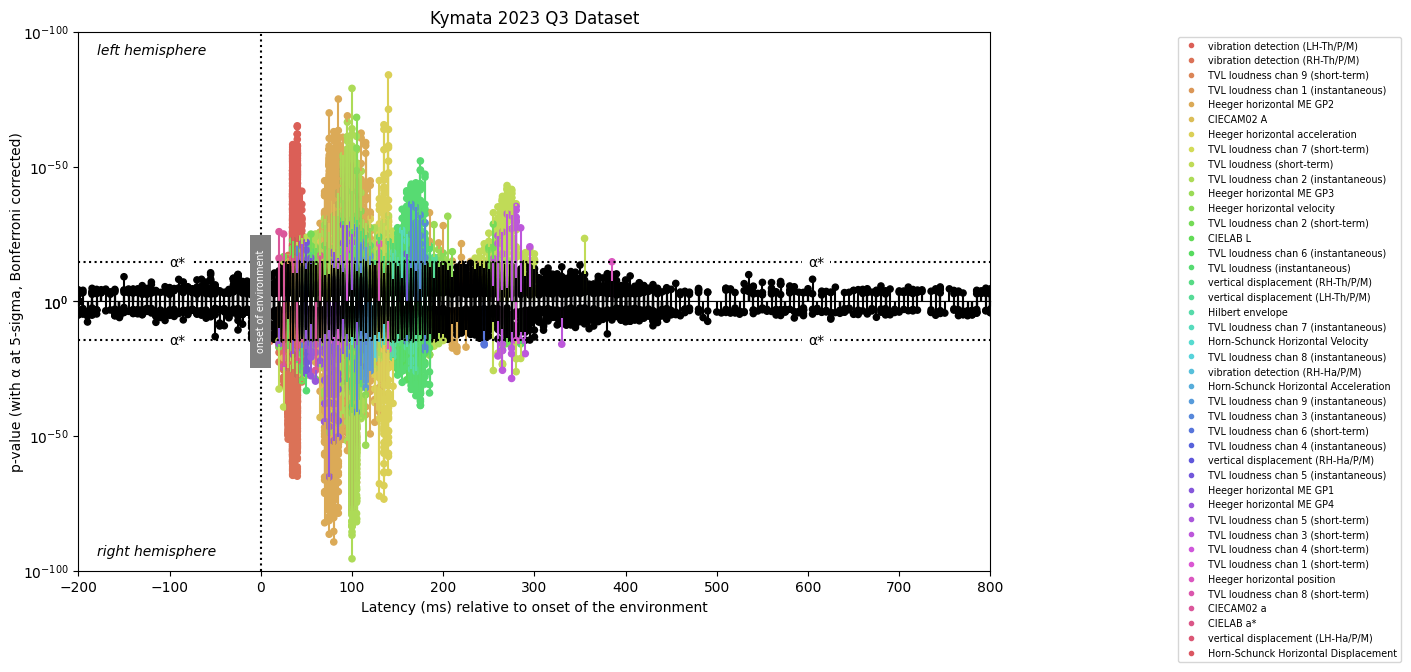

In [4]:
expression_set: HexelExpressionSet = KymataMirror2023Q3Dataset().to_expressionset()
hexels = build_hexel_dict_from_expression_set(expression_set)
hexels = convert_to_power10(hexels)
stem_plot(hexels, 'Kymata 2023 Q3 Dataset')

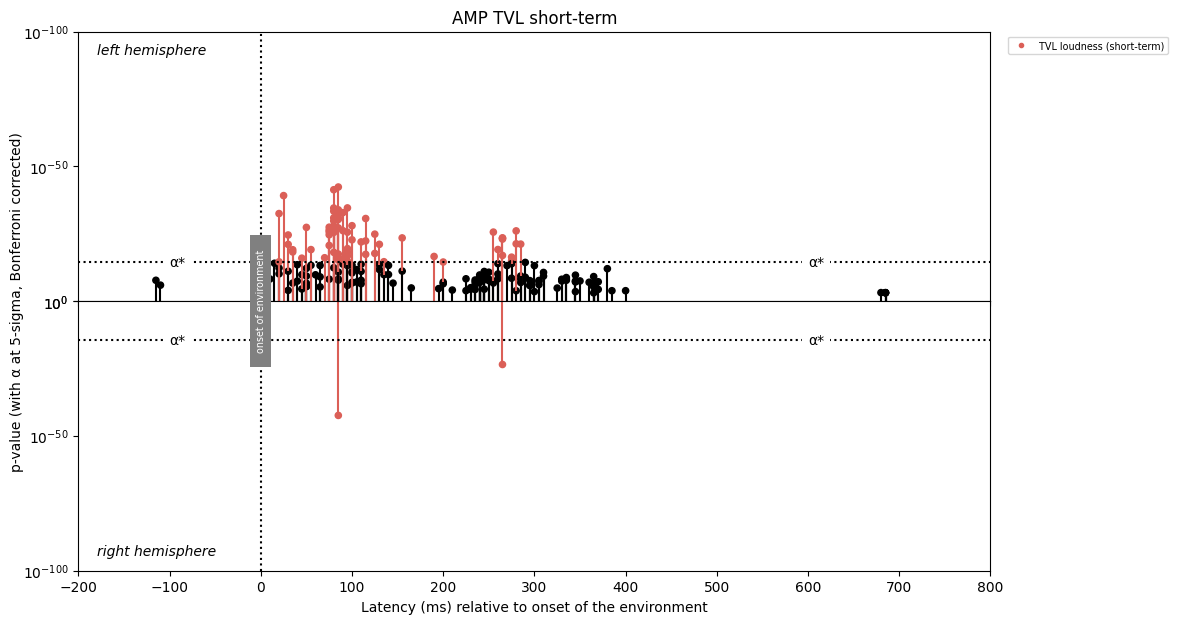

In [5]:
clusterer = AdaptiveMaxPooler()
temp_hexels = deepcopy(hexels)
temp_hexels = remove_excess_funcs(['TVL loudness (short-term)'], temp_hexels)
plot_denoised_vs_noisy(temp_hexels, clusterer, 'AMP TVL short-term')

### Analysis of Adaptive Max Pooler

Overall, I think it is still superior to MaxPooler due to its flexibility. The edge case where it fails is when there is a single bin inbetween two clusters. How about: 

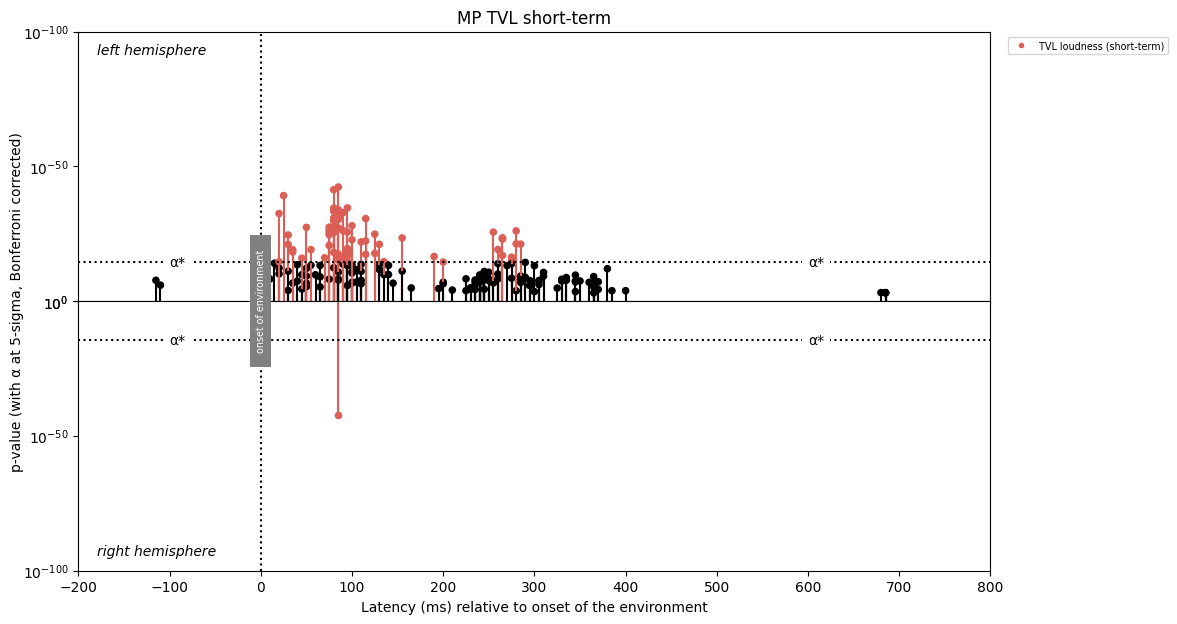

In [6]:
plot_denoised_vs_noisy(temp_hexels, MaxPooler(), 'MP TVL short-term')

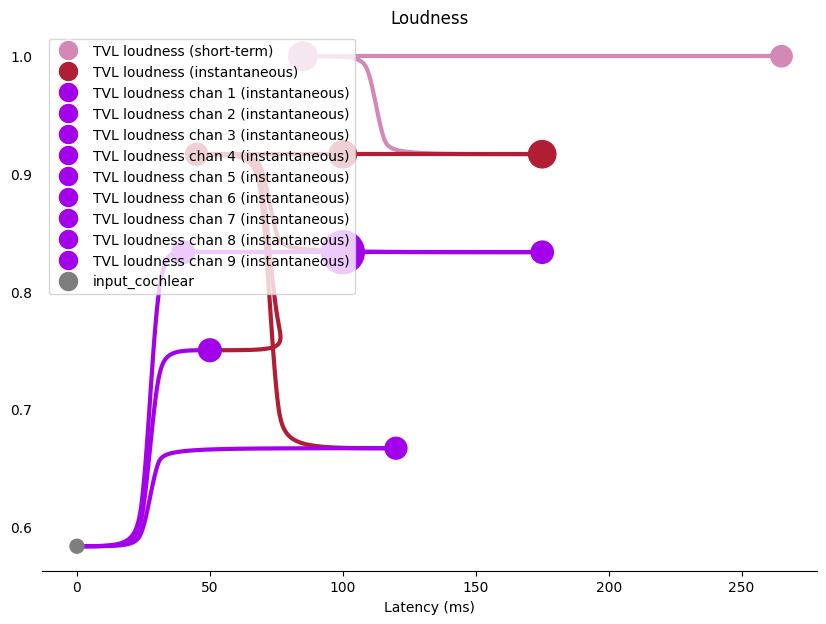

In [7]:
clusterer = AdaptiveMaxPooler()
denoised_hexels = clusterer.cluster(hexels, 'rightHemisphere')
inputs = ['input_cochlear']
function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }
builder = IPPMBuilder()
plotter = IPPMPlotter()
graph_dict = builder.build_graph(denoised_hexels, function_hier, inputs, 'rightHemisphere')
plotter.draw(graph_dict, function_colour_overrides, 'Loudness', 7, 10)

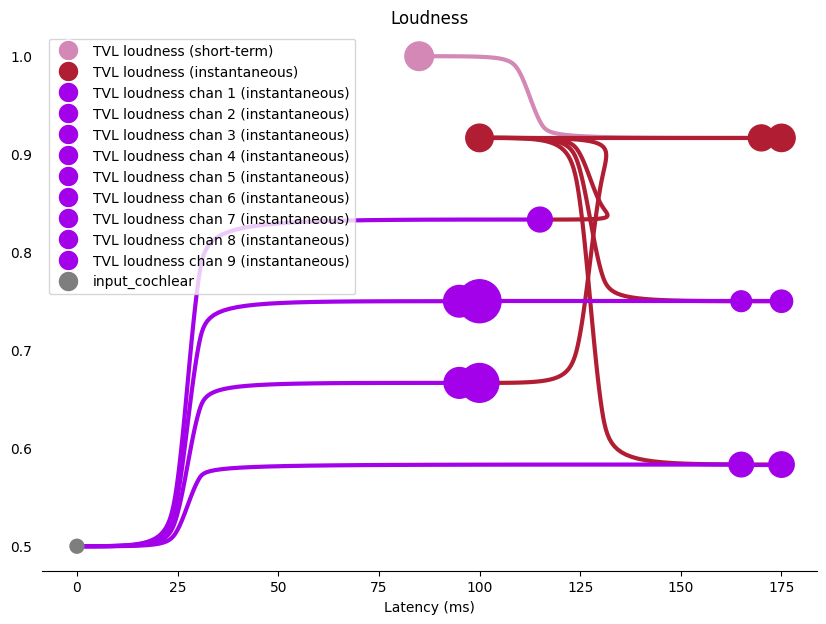

In [8]:
from kymata.ippm.denoiser import MaxPooler

clusterer = MaxPooler()
denoised_hexels = clusterer.cluster(hexels, 'rightHemisphere')
inputs = ['input_cochlear']
function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }
builder = IPPMBuilder()
plotter = IPPMPlotter()
graph_dict = builder.build_graph(denoised_hexels, function_hier, inputs, 'rightHemisphere')
plotter.draw(graph_dict, function_colour_overrides, 'Loudness', 7, 10)

## DBSCAN on 1D

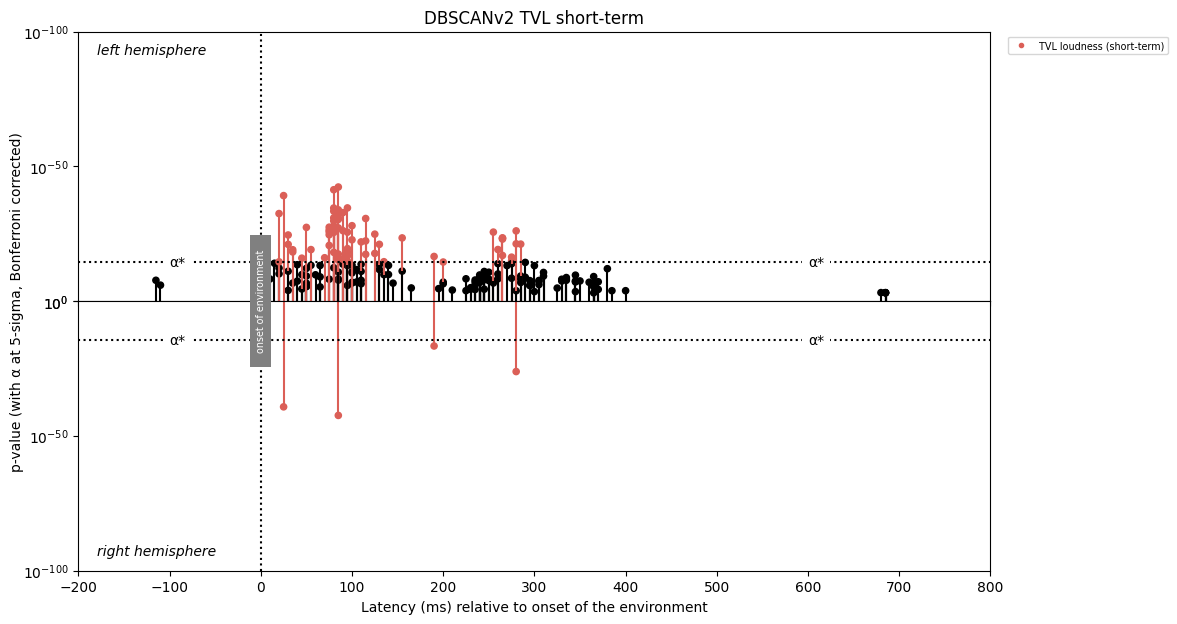

In [9]:
from kymata.ippm.denoiser import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN as DBSCAN_

class DBSCANv2(DBSCAN):
    def __init__(self, eps, min_samples):
        self._clusterer = DBSCAN_(eps=eps, min_samples=min_samples)
        
    def cluster(
        self, hexels: Dict[str, IPPMHexel], hemi: str, normalise: bool=False
    ) -> Dict[str, IPPMHexel]:
        hexels = deepcopy(hexels)
        for func, df in super()._hexels_to_df(hexels, hemi):
            if len(df) == 0:
                hexels = super()._update_pairings(hexels, func, [], hemi)
                continue

            fitted = (self._clusterer.fit(np.reshape(df['Latency'], (-1, 1))) 
                      if not normalise else
                      self._cluster.fit(np.reshape(normalize(df['Latency']), (-1, 1)))) # only cluster on latency.
            df['Label'] = fitted.labels_
            cluster_mins = super()._get_cluster_mins(df)
            hexels = super()._update_pairings(hexels, func, cluster_mins, hemi)
        return hexels

plot_denoised_vs_noisy(temp_hexels, DBSCANv2(eps=10, min_samples=2), 'DBSCANv2 TVL short-term')

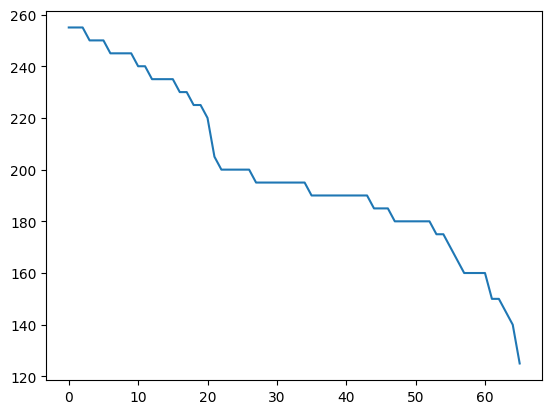

In [10]:
plot_k_dist_1D(temp_hexels['TVL loudness (short-term)'].right_best_pairings, k=4)

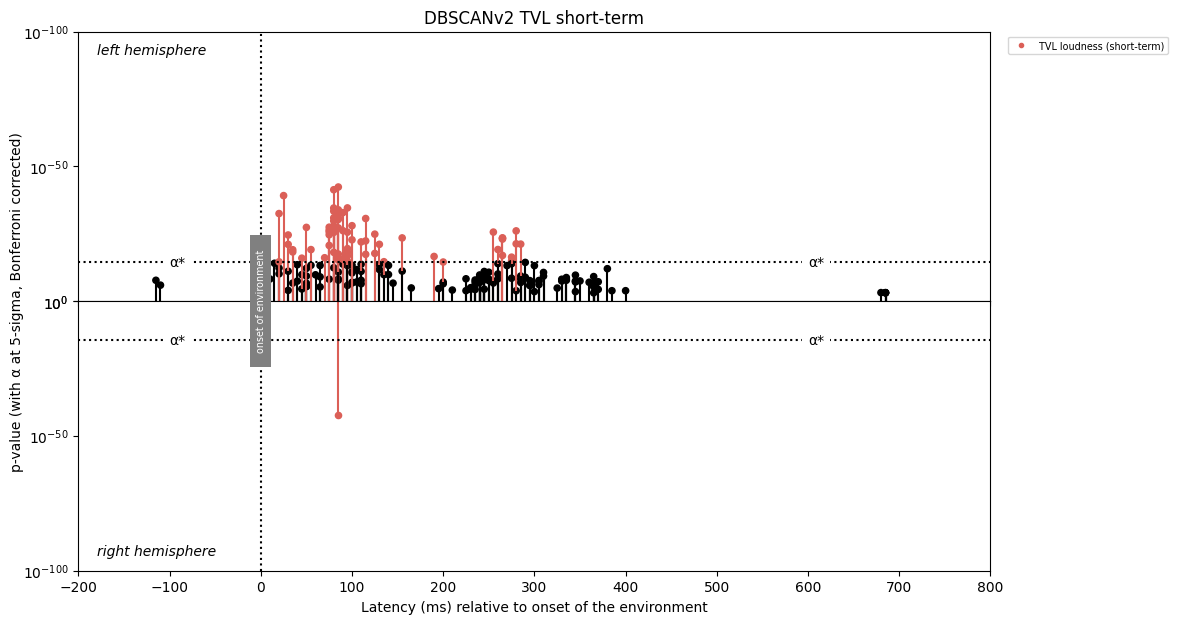

In [11]:
plot_denoised_vs_noisy(temp_hexels, DBSCANv2(eps=200, min_samples=4), 'DBSCANv2 TVL short-term')

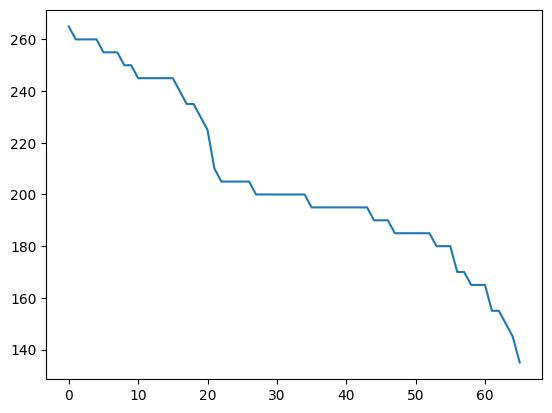

In [12]:
plot_k_dist_1D(temp_hexels['TVL loudness (short-term)'].right_best_pairings, k=1)

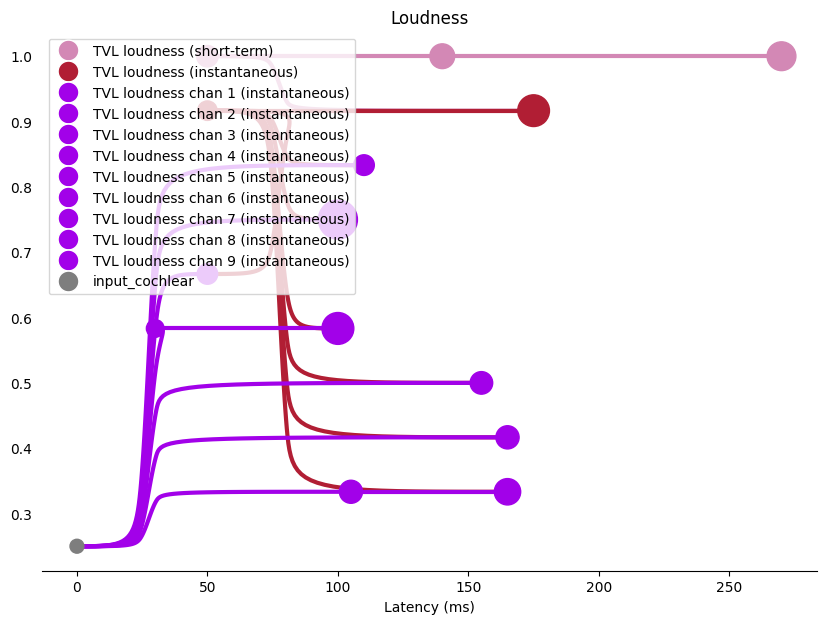

In [16]:


clusterer = DBSCANv2(eps=5, min_samples=2)
denoised_hexels = clusterer.cluster(hexels, 'leftHemisphere')
inputs = ['input_cochlear']
function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }
builder = IPPMBuilder()
plotter = IPPMPlotter()
graph_dict = builder.build_graph(denoised_hexels, function_hier, inputs, 'leftHemisphere')
plotter.draw(graph_dict, function_colour_overrides, 'Loudness', 7, 10)

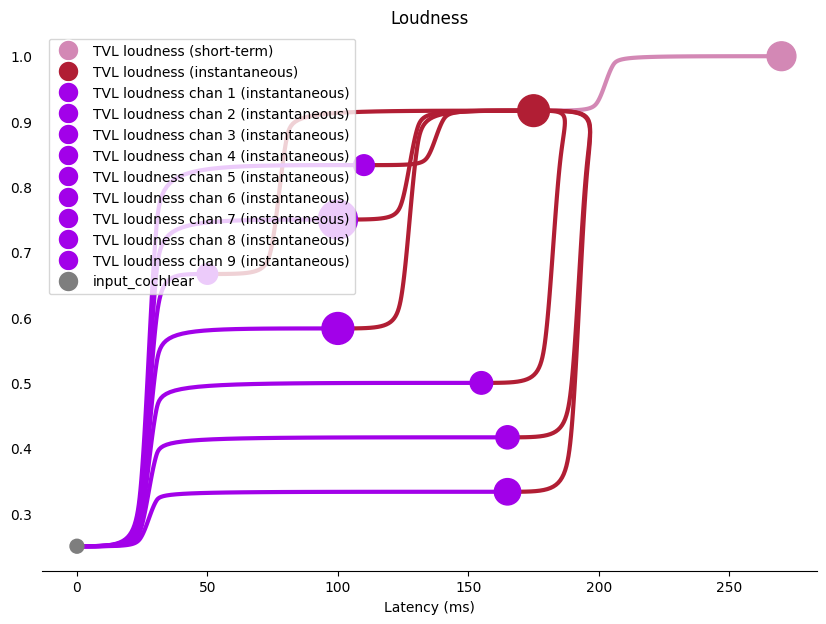

In [14]:
inputs = ['input_cochlear']
function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }

for func in function_hier.keys():
    if func == 'input_cochlear' or len(denoised_hexels[func].left_best_pairings) == 0:
        continue
    denoised_hexels[func].left_best_pairings = [min(denoised_hexels[func].left_best_pairings, key=lambda x: x[1])]
builder = IPPMBuilder()
plotter = IPPMPlotter()
graph_dict = builder.build_graph(denoised_hexels, function_hier, inputs, 'leftHemisphere')
plotter.draw(graph_dict, function_colour_overrides, 'Loudness', 7, 10)